# 1) Exploratory data analysis

1. y_train has a right-skewed distribution so logging the y_train would partially help with this problem. 

2. There are 29911 missing values in the train data
3. There are 24143 missing values in the test data

# 2) Data preparation 

In [4]:
# supress output
%%capture
!git clone --single-branch --branch v0.2dev https://github.com/scikit-learn-contrib/py-earth.git
%cd py-earth
!python setup.py install --cythonize

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import itertools as it

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier, StackingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression
import warnings
np.warnings.filterwarnings('ignore')
from pyearth import Earth
from catboost import CatBoostRegressor

In [41]:
# Loading the data
train = pd.read_csv('kaggle_train.csv')
test = pd.read_csv('kaggle_test.csv')
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

In [42]:
# Separate into test and train
y_train = train.y
X_train = train.drop("y", axis = 1)

X_test = test

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [43]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train_columns)

<Axes: xlabel='y', ylabel='Count'>

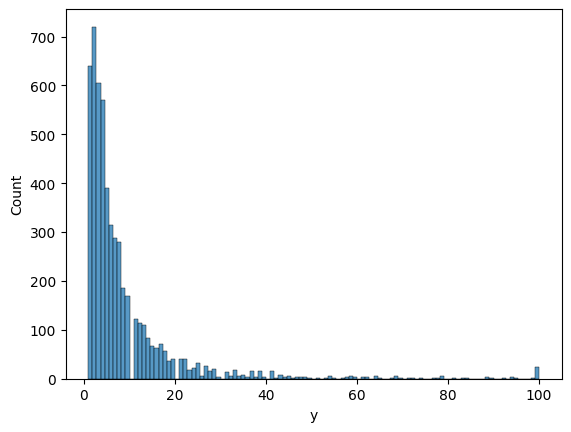

In [44]:
# y_train visualization
sns.histplot(data = y_train)

<Axes: xlabel='y', ylabel='Count'>

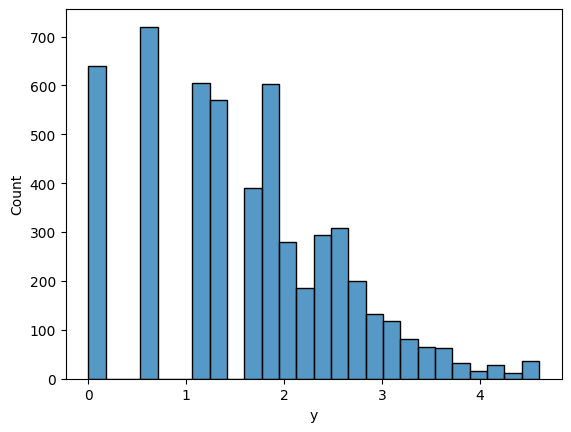

In [45]:
# y_train_log visualization
sns.histplot(data = np.log(y_train))

In [46]:
# Log transform the response variable
y_train_log = np.log(y_train)

In [47]:
# Number of missing values in the whole X_train dataset
X_train.isna().sum().sum()

29911

In [48]:
# Number of missing values in the whole X_test dataset
X_test.isna().sum().sum()

24143

In [49]:
# Imputing missing values with KNN Imputer
imputer = KNNImputer(n_neighbors = 20, weights = 'uniform')
imputed_arr = imputer.fit_transform(X_train)
X_imputed = pd.DataFrame(imputed_arr)
X_imputed.columns = [f'x{i+1}' for i in range(len(X_imputed.columns))]

In [50]:
X_imputed.isna().sum().sum()

0

In [51]:
# Imputing missing values for X_test
X_test_imputed = pd.DataFrame(imputer.transform(X_test))
X_test_imputed.columns = [f'x{i+1}' for i in range(len(X_test_imputed.columns))]

In [52]:
X_test_imputed.isna().sum().sum()

0

In [53]:
# MARS model with degree 1 fitted with y_train_log to select the useful variables
model = Earth(max_terms=500, max_degree=1, feature_importance_type='rss')
model.fit(X_imputed,y_train_log)

Earth(feature_importance_type='rss', max_degree=1, max_terms=500)

In [54]:
# MARS model with degree 1 fitted with y_train to select the useful variables
model_1 = Earth(max_terms=500, max_degree=1, feature_importance_type='rss')
model_1.fit(X_imputed,y_train)

Earth(feature_importance_type='rss', max_degree=1, max_terms=500)

In [55]:
# Getting feature importances from MARS model fitted with y_train_log
importance = pd.DataFrame(model.feature_importances_, columns = ['RSS'])
predictors = pd.DataFrame(X_imputed.columns, columns = ['Predictors'])
importance_df = pd.concat([predictors, importance], axis = 1).sort_values(by = 'RSS', ascending = False)
importance_df_small = importance_df.head(16)

In [56]:
# Getting feature importances from MARS model fitted with y_train
importance = pd.DataFrame(model_1.feature_importances_, columns = ['RSS'])
predictors = pd.DataFrame(X_imputed.columns, columns = ['Predictors'])
importance_df = pd.concat([predictors, importance], axis = 1).sort_values(by = 'RSS', ascending = False)
importance_df_small_1 = importance_df.head(28)

In [57]:
# List of features selected
selected_features = importance_df_small.Predictors.tolist()
importance_df_small_1_list = importance_df_small_1.Predictors.tolist()
[selected_features.append(x) for x in importance_df_small_1_list if x not in selected_features]
len(selected_features)

37

In [58]:
# Making a new train dataframe with all the predictors that are selected
X_train_small = X_imputed.loc[:, selected_features]

In [59]:
# Making a new test dataframe with all the predictors that are selected
X_test_small = X_test_imputed.loc[:, selected_features]

# 3) Developing the model(s)

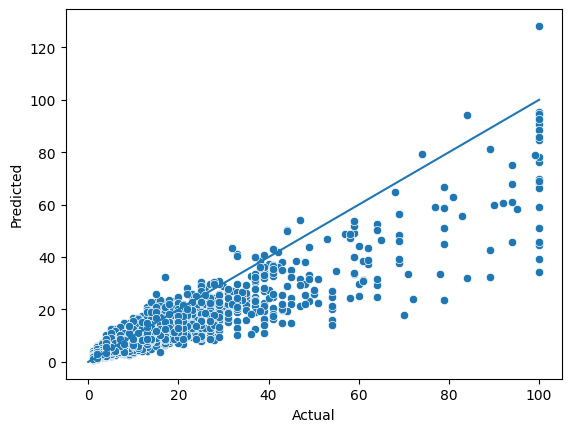

In [60]:
# Basic Catboost Model
model_cat = CatBoostRegressor(random_state = 1, verbose = False).fit(X_train_small, y_train_log)

#MAE of the optimized model on test data
y_train_pred=model_cat.predict(X_train_small)

# Dataframe with both the predicted and actual y-train values unlogged
y_train_comparison = pd.concat([pd.DataFrame(np.exp(y_train_pred)), y_train], axis = 1)
y_train_comparison.rename(columns={0: "Predicted", "y": "Actual"}, inplace = True)

# Plot the comparison between actual and predicted
sns.scatterplot(data = y_train_comparison, y = 'Predicted', x = 'Actual')
plt.plot([0,100], [0,100])

In [61]:
# Find the difference between the predicted and the actual values
y_train_comparison['Difference'] = y_train_comparison.Predicted - y_train_comparison.Actual

# Find the average difference aka average error
mean_diff = y_train_comparison.Difference.mean()

# Add this average error into the model to correct the slope
y_test_pred = np.exp(model_cat.predict(X_test_small)) - mean_diff

# 4) Ensemble

I did try many models and ensemble many of them, but I do not remember which one was the best since it has been a while since the time I produced my best RMSE.  However, with just a basic Catboost model, I was able to develop a model that has an RMSE of 8.56. Therefore, I would just report this model.

In [62]:
# Full test dataset
test_full = pd.read_csv('kaggle_test.csv')

In [63]:
y = pd.Series(y_test_pred, name = 'y')
y[y<=1] = 1
sub = pd.concat([test_full['id'], y], axis = 1, ignore_index=True)
sub.columns = ['id',"y"]

In [64]:
sub.dropna(inplace = True)
sub.id = sub.id.apply(np.int32)

In [65]:
sub = sub.set_index('id')

In [66]:
from google.colab import files
sub.to_csv('submission.csv', encoding = 'utf-8-sig', index = True) 
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>